# Self-Driving Car Engineer Nanodegree


## Project 3: Behavioral Cloning
August 2017


---

## Goal
The goal of this project is to build a machine learning model that can successfully steer a car around a race track that it's never encountered before.

The details for this project are located here at [Udacity's Github repo](https://github.com/udacity/CarND-Behavioral-Cloning-P3). My implementation of the project can be found [here at my Github repo](https://github.com/tommytracey/udacity/tree/master/self-driving-nano/projects/3-behavioral-cloning).


---
## Initial Setup

#### Import Modules

In [2]:
import csv
import cv2
import keras
import keras.backend
from keras.callbacks import ModelCheckpoint, Callback
from keras.layers.core import Activation, Dense, Dropout, Flatten, Lambda, Reshape
from keras.layers.convolutional import Conv2D, Cropping2D
from keras.layers.pooling import MaxPooling2D
from keras.layers.advanced_activations import ELU
from keras.models import Sequential, model_from_json
from keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import Adam
from keras.regularizers import l2
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import os
import pandas as pd
import random
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
import tensorflow as tf
from tqdm import tqdm



Using TensorFlow backend.


#### Verify that Keras is using Tensforflow backend

The Keras backend uses Theano by default and changing it to Tensorflow can be tricky via Jupyter. Simply updating the config json file `$HOME/.keras/keras.json` as directed in [Keras backend documentation](https://keras.io/backend/) did not work for me. Trying to set it _before or after loading the notebook_ did not work eithter when using:

`$ os.environ["KERAS_BACKEND"]="tensorflow"`

The only way I could reliably set Tensorflow as the backend was to use the following command **UPON loading the notebook**:

`$ KERAS_BACKEND=tensorflow jupyter notebook`

(NOTE: You can also append `--NotebookApp.iopub_data_rate_limit=10000000000` to the above command if your notebook includes a lot of visualizations. This will help prevent the kernel from crashing and/or causing you to lose your connection to your AWS EC2 instance.)

Re: the backend, **the cell below only provides a sanity check that the backend is configured as expected**. Note that the version of Tensorflow being used by Keras may be different than the one you typically run in your environment. 

[This post](https://www.nodalpoint.com/switch-keras-backend/) by Christos-Iraklis Tsatsoulis provides even more detail if you'd like to further understand the issues and automate the setup process.

In [ ]:
print('Keras version: ', keras.__version__)
print('Tensorflow version: ', tf.__version__)
print('Keras backend: ', keras.backend.backend())
print('keras.backend.image_dim_ordering = ', keras.backend.image_dim_ordering())

os.environ["KERAS_BACKEND"] = "tensorflow"
if keras.backend.backend() != 'tensorflow':
    raise BaseException("This script uses other backend")
else:
    keras.backend.set_image_dim_ordering('tf')
    print("\nBackend OK")

---
# Step 1: Load and preview the data

---

### Original Data Set (provided by Udacity)

In [3]:
# Load UDACITY data into a list
with open('data/udacity/driving_log.csv', newline='') as f:
    udacity_data = list(csv.reader(f, skipinitialspace=True, delimiter=',', quoting=csv.QUOTE_NONE))
    
# Load UDACITY data from .csv and preview it in Pandas dataframe
udacity_df = pd.read_csv('data/udacity/driving_log.csv', header=0)

print('total rows: ', len(udacity_df))
udacity_df.head()

total rows:  8036


,center,left,right,steering,throttle,brake,speed
0,IMG/center_2016_12_01_13_30_48_287.jpg,IMG/left_2016_12_01_13_30_48_287.jpg,IMG/right_2016_12_01_13_30_48_287.jpg,0.0,0.0,0.0,22.148290
1,IMG/center_2016_12_01_13_30_48_404.jpg,IMG/left_2016_12_01_13_30_48_404.jpg,IMG/right_2016_12_01_13_30_48_404.jpg,0.0,0.0,0.0,21.879630
2,IMG/center_2016_12_01_13_31_12_937.jpg,IMG/left_2016_12_01_13_31_12_937.jpg,IMG/right_2016_12_01_13_31_12_937.jpg,0.0,0.0,0.0,1.453011
3,IMG/center_2016_12_01_13_31_13_037.jpg,IMG/left_2016_12_01_13_31_13_037.jpg,IMG/right_2016_12_01_13_31_13_037.jpg,0.0,0.0,0.0,1.438419
4,IMG/center_2016_12_01_13_31_13_177.jpg,IMG/left_2016_12_01_13_31_13_177.jpg,IMG/right_2016_12_01_13_31_13_177.jpg,0.0,0.0,0.0,1.418236


### New Data Set (with addition of self-generated data)

In [4]:
# Load data into list **BOTH TRACKS**
with open('data/track1/more-turns/driving_log.csv', newline='') as f:
    track_data = list(csv.reader(f, skipinitialspace=True, delimiter=',', quoting=csv.QUOTE_NONE))

# Load data from .csv and preview it in Pandas dataframe
track_df = pd.read_csv('data/track1/more-turns/driving_log.csv', header=0)

print('total records: ', len(track_data))
print('\nfirst record:\n', track_data[0])
print('\nDataframe header:\n')
track_df.head()

total records:  3478

first record:
 ['center', 'left', 'right', 'steering', 'throttle', 'brake', 'speed']

Dataframe header:



,center,left,right,steering,throttle,brake,speed
0,/Users/thomastracey/Desktop/track_1/more-turns...,/Users/thomastracey/Desktop/track_1/more-turns...,/Users/thomastracey/Desktop/track_1/more-turns...,0.000000,0.0,0,25.95815
1,/Users/thomastracey/Desktop/track_1/more-turns...,/Users/thomastracey/Desktop/track_1/more-turns...,/Users/thomastracey/Desktop/track_1/more-turns...,0.000000,0.0,0,25.74943
2,/Users/thomastracey/Desktop/track_1/more-turns...,/Users/thomastracey/Desktop/track_1/more-turns...,/Users/thomastracey/Desktop/track_1/more-turns...,-0.100000,0.0,0,25.53938
3,/Users/thomastracey/Desktop/track_1/more-turns...,/Users/thomastracey/Desktop/track_1/more-turns...,/Users/thomastracey/Desktop/track_1/more-turns...,-0.300000,0.0,0,25.28677
4,/Users/thomastracey/Desktop/track_1/more-turns...,/Users/thomastracey/Desktop/track_1/more-turns...,/Users/thomastracey/Desktop/track_1/more-turns...,-0.123654,0.0,0,25.11549


In [ ]:
# Load data into list
with open('data/track1/driving_log.csv', newline='') as f:
    track1_data = list(csv.reader(f, skipinitialspace=True, delimiter=',', quoting=csv.QUOTE_NONE))

# Load data from .csv and preview it in Pandas dataframe
track1_df = pd.read_csv('data/track1/driving_log.csv', header=0)

print('total records: ', len(track1_data))
print('\nfirst record:\n', track1_data[0])
print('\nDataframe header:\n')
track1_df.head()

#### Data Set: Initial Observations
We can see from the table above that the driving data includes:
- relative paths to .jpg images from three different camera angles (center, left, right)
- floating point measurements of the vehicle's steering angle, throttle, brake, and speed
- the data appears to be time series, although no time stamps are included

## Preview the driving images

The driving images are the training features for our model. We need to look at samples of these images and start thinking about how various characteristics might affect the model (positively or negatively). 

In [5]:
## Preview a random set of images from each camera angle

index = random.randint(0, len(udacity_df))
img_dir = 'data/udacity/'

center_img_orig = mpimg.imread(img_dir + udacity_data[index][0])
left_img_orig = mpimg.imread(img_dir + udacity_data[index][1])
right_img_orig = mpimg.imread(img_dir + udacity_data[index][2])

center_steer = udacity_data[index][3]

In [ ]:
# Display visualizations in the notebook
%matplotlib inline

plt.figure(figsize=(20,5))

plt.subplot2grid((1, 3), (0, 0));
plt.axis('off')
plt.title('left camera')
plt.text(0, left_img_orig.shape[0]+15, ('shape: ' + str(left_img_orig.shape)))
plt.imshow(left_img_orig, cmap="gray")

plt.subplot2grid((1, 3), (0, 1));
plt.axis('off')
plt.title('center camera')
plt.text(0, center_img_orig.shape[0]+15, ('shape: ' + str(center_img_orig.shape)))
plt.text(0, center_img_orig.shape[0]+30, ('steering angle: ' + center_steer))
plt.imshow(center_img_orig, cmap="gray")

plt.subplot2grid((1, 3), (0, 2));
plt.axis('off')
plt.title('right camera')
plt.text(0, right_img_orig.shape[0]+15, ('shape: ' + str(right_img_orig.shape)))
plt.imshow(right_img_orig, cmap="gray")

#### Driving Images: Initial Observations
We can see from the images above that:
- the images are taken in the front of the car (no side or rear angles)
- each image is 160x320 with 3 RGB color channels
- there is quite a bit of superfluous data, i.e. data that won't benefit the model; for example the sky, hills, trees in the background, as well as the hood of the car).

If you view enough images or actually run the simulator, you also see that:
- there are a lot of turns in the road (duh!), but since the track ultimately ends where it started, there seems to be more turns in one direction than the other
- the lane markings change shape and color at different points in the track, and at some points there are no markings at all!
- all of the images are consistently bright; no glare, no darkness, and no shadows that you'd usually encounter with normal driving

Given the simulation takes place on a race track (not a highway), the road is free of additional cars, traffic signs, lanes, etc. We won't account for these in this project, but a more robust driving model would need training data that included these conditions. 

That said, many of the other items above can create biases in our model and cause it to overfit the specific driving conditions within this particular simulation. We need to correct for these so that our model learns to drive in a variety of conditions we might find on other tracks. We'll do this by pre-processing and augmenting our training data throughout the sections to follow. But first let's look at our target data (steering angles) to see if there's anything else we need to correct for. 

## Examine the steering angles
The steering angles are our target data for training the model. That is, based on the images fed into the model while the car is driving along the track, the model will predict the appropriate steering angle to navigate the patch of road ahead.

In [6]:
## Steering angle distribution function

def show_dist(angles):
    angles = np.array(angles)
    num_bins = 35    
    avg_per_bin = len(angles) / num_bins
    
    print('Total records:', angles.shape[0])
    print('Avg per bin: {:0.1f}'.format(avg_per_bin))
    
    hist, bins = np.histogram(angles, num_bins)
    width = 0.8 * (bins[1] - bins[0])
    center = (bins[:-1] + bins[1:]) / 2

    plt.title('Distribution of Steering Angles')
    plt.bar(center, hist, align='center', width=width)
    plt.plot((np.min(angles), np.max(angles)), (avg_per_bin, avg_per_bin), 'k-')
    plt.show()


#### Distribution &mdash; Udacity Data

In [ ]:
angles = udacity_df.steering.tolist()
show_dist(angles)


**Steering Angle Observations**:

We can see from the graph above that an overwhelming amount of the target data are steering angles close to zero (i.e., when the car is driving straight). This biases our model to drive the car straight and make it's difficult to learn how to navigate turns. 

It also seems there may be an imbalance in left vs. right turning data (although not as much as I had expected). It's not clear how big of an impact this would have on the model, but there's a chance the model could learn to turn more effectively in one direction than the other. Just to be safe we'll correct for this by ensuring there are equal quantities of left and right steering data after pre-processing. 

#### Distribution &mdash; Self-generated data + Udacity data

Total records: 3477
Avg per bin: 99.3


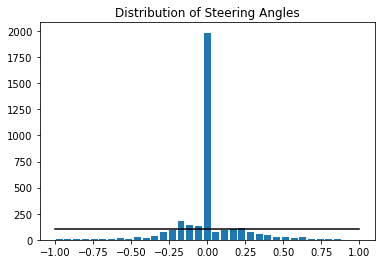

In [79]:
angles = track_df.steering.tolist()
show_dist(angles)

---
# Step 2: Data pre-processing
---

### 2.1 | Overview of Data Sources and Splits

**Data Sources**: 
- There are two tracks, but all of the original training and validation data is generated by driving the simulator on **Track 1**.
- Udacity provides an intial set of "good" data to get us started.
- Additional data is gathered by running the simulator myself. 

**Training Data**:
- The training data set includes the original image data captured from the simulator on Track 1, plus any additional data generated via pre-processing and augmentation. 

**Validation Data**:
- The validation data will contain the original image data captured from the simulator on Track 1, with only a pre-process to create a more balanced distribution (i.e., reduce the 'drive straight' bias). No other pre-processing or augmentation is included. This ensures we can properly validate whether changes we're making to the model or training data are increasing or decreasing the model's performance. 

**Test Data**:
- We'll test the model's ability to generalize by running it on **Track 2**. So, the simulator input images from Track 2 will serve as our test data.

In [7]:
## Define data sources and their corresponding image directory

# available data sources/groupings
sources = ['udacity', 'self', 'track1', 'track2', 'both_tracks', 'track1/more-turns', 'track1/t1-mouse', 'track1/t1-center', 'track1/recovery'] 

# source used for building the pipeline below
source = sources[5]                        

## Creates correct directory based on the image source
def get_img_dir(source):
    return "data/" + source + "/IMG/"


### 2.2 | Data Hygiene

Before going any further there are few aspects of the data we need to cleanup to make the data easier to work with.

1. We're only using the steering data to train the model, so we can prune out the other measurements (throttle, brake, and speed).
2. Remove the directory from image path data. We'll be moving our data around and we only want the image filename. 
3. Cast all of the steering data as floats. In the .csv they're cast as strings. 

In [8]:
## Hygiene function

# column references for source data: 
# 0=center_img, 1=left_img, 2=right_img, 3=steering, 4=throttle, 5=brake, 6=speed

def clean(source_data):
    '''Performs basic hygiene functions listed above.
    
    Arguments:
    source_data: source data in list format with header row
    '''
    data_clean = []

    for row in source_data[1:]:
        # Remove directory from image paths
        center = row[0].split('/')[-1]
        left = row[1].split('/')[-1]
        right = row[2].split('/')[-1]

        # Only grab the steering data and cast as float
        angle = float(row[3])

        data_clean.append([center, left, right, angle])
    
    return data_clean


#### Data hygiene

In [9]:
track_clean = clean(track_data)

In [10]:
print('number of records: ', len(track_clean))

number of records:  3477


In [11]:
# Preview first three records
track_clean[0:3]

[['center_2017_08_16_13_12_23_054.jpg',
  'left_2017_08_16_13_12_23_054.jpg',
  'right_2017_08_16_13_12_23_054.jpg',
  0.0],
 ['center_2017_08_16_13_12_23_121.jpg',
  'left_2017_08_16_13_12_23_121.jpg',
  'right_2017_08_16_13_12_23_121.jpg',
  0.0],
 ['center_2017_08_16_13_12_23_209.jpg',
  'left_2017_08_16_13_12_23_209.jpg',
  'right_2017_08_16_13_12_23_209.jpg',
  -0.1]]

### 2.3 | Create Validation and Test Sets

In [12]:
## Create training and test sets

X_train_pre1 = [i[0:3] for i in track_clean]     # list of image filenames for all 3 cameras
y_train_pre1 = [i[3] for i in track_clean]     # list of steering angles

# Split training and testing data
X_train_pre2, X_test, y_train_pre2, y_test = \
                train_test_split(X_train_pre1, y_train_pre1, test_size=0.01, random_state=73)

# Split training and validation data
X_train_pre3, X_valid, y_train_pre3, y_valid = \
                train_test_split(X_train_pre2, y_train_pre2, test_size=0.1, random_state=56)

# Remove left and right camera data from validation and test splits
X_valid = [i[0] for i in X_valid]
X_test = [i[0] for i in X_test]

# Number of training examples
n_train = len(X_train_pre3)

# Number of training examples
n_valid = len(X_valid)

# Number of test examples
n_test = len(X_test)

# Verify that all counts match
print('Number of training samples: ', n_train)
print('Number of validation samples: ', n_valid)
print('Number of test samples: ', n_test)
print('Total: ', n_train + n_valid + n_test)

Number of training samples:  3097
Number of validation samples:  345
Number of test samples:  35
Total:  3477


---
# Step 3: Data Augmentation
---
In the following section we'll explore ways to augment our **training data** to help the model extract the most important features related to steering the car. 

In [13]:
# Augmentation prep: Rejoin the training image names and angles into a single data set

train_data = []
for i in range(len(y_train_pre3)):
    train_data.append([X_train_pre3[i][0], X_train_pre3[i][1], X_train_pre3[i][2], y_train_pre3[i]])

In [14]:
train_data[0]

['center_2017_08_16_13_25_39_286.jpg',
 'left_2017_08_16_13_25_39_286.jpg',
 'right_2017_08_16_13_25_39_286.jpg',
 0.0]

### 3.1 | Overview of Augmentations Strategies

< insert table showing which functions are applied to each data set and when in the pipeline >

### 3.2 | Seperate C/L/R camera data and adjust steering angles for left and right turns
Right now, each row of the data set contains three camera angles (center, left, right) and one steering angle which pertains to the center camera. In order to utilize all of the different camera data, we need to: 

1. Separate the data for each of the different camera angles (only one camera angle per row)
2. Adjust the steering angles for the left and right cameras _while the car is turning_. This will compensate for their respective vantage points relative to the center of the car. That is, the steering angle for a right turn should be sharper from the persective of the left camera (and vice versa). 

In [16]:
turn_thresh = 0.1   # the angle threshold used to identify left and right turns
# ang_corr = np.random.uniform(0.25, 0.30)   # the steering angle correction for left and right cameras
ang_corr = 0.25

def steer_adj(angle):
    '''Calculates the absolute value of the steering angle correction for images from 
    the left and right cameras.
    '''
    new_angle = min((abs(angle)+np.random.uniform(0.25, 0.30)), 1.0)
    
    return new_angle


In [17]:
## Function for adding left and right camera angles

def split_3cam(train_data, keep_prob):
    '''Creates a list of image filenames and angles now with one camera 
    input per row (not three). 
        
    Arguments:
    train_data: list of training image filenames and angles. Each row 
                has images names for all three cameras.
    keep_prob: probability of keeping zero steering angle records 
    
    Returns:
    a list of tuples [(image filename, angle)]
    
    '''
    train_3cam = []

    for row in train_data:
        
        # Center camera
        img_center, ang_center = row[0], row[3]
        
        # Capture right turn data
        if ang_center > turn_thresh:
            # center camera, orig steering angle
            train_3cam.append((img_center, ang_center))

            # left camera, adjusted steering angle
            img_left, ang_left = row[1], steer_adj(row[3])
            train_3cam.append((img_left, ang_left))

        # Capture left turn data
        elif ang_center < -turn_thresh:
            # center camera, orig steering angle
            train_3cam.append((img_center, ang_center)) 

            # right camera, adjusted steering angle
            img_right, ang_right = row[1], -steer_adj(row[3])  
            train_3cam.append((img_right, ang_right))

        # Capture straight driving data
        else: 
#             if ang_center == 0:
#                 if np.random.rand() <= keep_prob:
#                     train_3cam.append((img_center, ang_center))
#             else:
#                 train_3cam.append((img_center, ang_center))
            if np.random.rand() <= keep_prob:
                train_3cam.append((img_center, ang_center))
    
    return train_3cam

#### Create dataset with all 3 cameras

In [ ]:
train_3cam = split_3cam(train_data, 1.0)
angles = [i[1] for i in train_3cam]
show_dist(angles)

#### Flatten the distribution (a little)
As we can see from the graph above, there's still MUCH more 'drive straight' data than turning data. So, below we remove most of the zero angle data to somewhat normalize the distribution. We'll actually equalize the distribution later on. For now, we just want to make it more balanced and get a more detailed look at the other parts of the distribution. 

In [ ]:
keep_3cam = 0.5
train_3cam = split_3cam(train_data, keep_3cam)
angles = [i[1] for i in train_3cam]
show_dist(angles)

### 3.3 | Crop the images (preview only)
There is a lot of background information in the image that isn't useful for training the model (e.g. trees, sky, birds). Cropping the image helps reduce the level of noise so the model can more easily identify the most important features, namely the turns in the road directly ahead.

**NOTE:**
The crop function is not actually performed during pre-processing. It happens via the `Cropping2D()` layer near the beginning of the model, just after normalization. We do cropping at this point because we also want to crop the input images from the simulator during testing. But, for visualization purposes in this notebook, we'll start showing images in their cropped formed now...so that we can see how other transformations we're making will affect what the model "sees" later in the pipeline.

In [18]:
## Define crop points

# Crop settings provided to Keras Cropping2D layer within the model
crop_set = (60, 20), (20, 20)   # number of pixels to remove from (top, bottom), (left, right)
    
# Model input_shape (160, 320, 3) 
orig_shape = center_img_orig.shape  

# Image shape after cropping
crop_shape = (
    orig_shape[0]-(crop_set[0][0]+crop_set[0][1]), \
    orig_shape[1]-(crop_set[1][0]+crop_set[1][1]),  \
    orig_shape[2]
)

# Resulting crop points (for previewing images in notebook)
h1, h2 = (crop_set[0][0], orig_shape[0]-crop_set[0][1])
w1, w2 = (crop_set[1][0], orig_shape[1]-crop_set[1][1])
crop_points = (h1, h2, w1, w2)

print('orig_shape: ', orig_shape)
print('crop_shape: ', crop_shape)
print('crop points (h1, h2, w1, w2) = {}'.format(crop_points))

orig_shape:  (160, 320, 3)
crop_shape:  (80, 280, 3)
crop points (h1, h2, w1, w2) = (60, 140, 20, 300)


In [19]:
## Cropping function (again, for notebook display purposes only)

def crop(image_data):
    h1, h2, w1, w2 = crop_points
    
    if isinstance(image_data, str):
        img_crop = mpimg.imread(get_img_dir(source) + image_data)[h1:h2,w1:w2]
    else:
        img_crop = image_data[h1:h2,w1:w2]
    
    return img_crop


### 3.4 | Flip the images
This function was originally executed later in the pipeline within the generator. But, I decided to move it up to the pre-processing stage since it inherently adds more images while balancing the steering angle distribution. Doing this earlier in the process helps prevent some data loss when we attempt to equalize the distribution in the final step of pre-processing. The equalization step (randomly) removes a significant chunk of data, so it's better to add the flipped images beforehand as it increases the chances that at least one version of an image is included in the training data (i.e., it adds more samples and greater variety to our training set).

In [20]:
## Flip functions


# For flipping batches of images and angles input as a list

def flip_n(data_3cam):
    '''Creates a flipped version of every input image and angle. 
    
    Returns both the original and the flipped versions in list form. 
    '''
    image_names = [i[0] for i in data_3cam]
    angles = [i[1] for i in data_3cam]
    
    images_flip = []
    angles_flip = []

    for i in range(len(angles)):
        # Grab the image
        image = mpimg.imread(get_img_dir(source) + image_names[i])
        
        # Append the original image and angle
        images_flip.append(image)
        angles_flip.append(angles[i])
        
        # Append the flipped versions
        images_flip.append(cv2.flip(image, 1))
        angles_flip.append(-angles[i])

    return list(zip(images_flip, angles_flip))


# Flips a single image input as either a string or array

def flip(image_data):
    if isinstance(image_data, str):
        image = mpimg.imread(get_img_dir(source) + image_data)
    else:
        image = image_data
        
    return np.array(cv2.flip(image, 1))


#### Preview Flipped Images
Again, we also crop the images here for demo purposes, so we get a better idea of what the model will ultimately see.

In [ ]:
## Preview flipped images

index = random.randint(0, len(track1_clean))

# Select a random set of images to crop
center_img_crop = crop(track1_clean[index][0])
left_img_crop = crop(track1_clean[index][1])
right_img_crop = crop(track1_clean[index][2])

# Create flipped versions
center_img_flip = flip(center_img_crop)
left_img_flip = flip(left_img_crop)
right_img_flip = flip(right_img_crop)

# Calculate steering angles
center_steer = float(track1_clean[index][3])
left_steer = None
left_steer_flip = None 
right_steer = None
right_steer_flip = None
if center_steer > turn_thresh:
    left_steer = steer_adj(center_steer)
    left_steer_flip = -steer_adj(center_steer)
if center_steer < -turn_thresh:
    right_steer = -steer_adj(center_steer)
    right_steer_flip = steer_adj(center_steer)
    
# Display visualizations in the notebook
plt.figure(figsize=(20,6))

# Cropped versions
plt.subplot2grid((2, 3), (0, 0));
plt.axis('off')
plt.title('Left Camera (cropped)')
plt.text(0, left_img_crop.shape[0]+15, ('shape: ' + str(left_img_crop.shape)))
plt.text(0, left_img_crop.shape[0]+30, ('steering angle: ' + str(left_steer)))
plt.imshow(left_img_crop, cmap="gray")

plt.subplot2grid((2, 3), (0, 1));
plt.axis('off')
plt.title('Center Camera (cropped)')
plt.text(0, center_img_crop.shape[0]+15, ('shape: ' + str(center_img_crop.shape)))
plt.text(0, center_img_crop.shape[0]+30, ('steering angle: ' + str(center_steer)))
plt.imshow(center_img_crop, cmap="gray")

plt.subplot2grid((2, 3), (0, 2));
plt.axis('off')
plt.title('Right Camera (cropped)')
plt.text(0, right_img_crop.shape[0]+15, ('shape: ' + str(right_img_crop.shape)))
plt.text(0, right_img_crop.shape[0]+30, ('steering angle: ' + str(right_steer)))
plt.imshow(right_img_crop, cmap="gray")

# Flipped version
plt.subplot2grid((2, 3), (1, 0));
plt.axis('off')
plt.title('Left Camera (cropped + flipped)')
plt.text(0, left_img_flip.shape[0]+15, ('shape: ' + str(left_img_flip.shape)))
plt.text(0, left_img_flip.shape[0]+30, ('steering angle: ' + str(left_steer_flip)))
plt.imshow(left_img_flip, cmap="gray")

plt.subplot2grid((2, 3), (1, 1));
plt.axis('off')
plt.title('Center Camera (cropped + flipped)')
plt.text(0, center_img_flip.shape[0]+15, ('shape: ' + str(center_img_flip.shape)))
plt.text(0, center_img_flip.shape[0]+30, ('steering angle: ' + str(-center_steer)))
plt.imshow(center_img_flip, cmap="gray")

plt.subplot2grid((2, 3), (1, 2));
plt.axis('off')
plt.title('Right Camera (cropped + flipped)')
plt.text(0, right_img_flip.shape[0]+15, ('shape: ' + str(right_img_flip.shape)))
plt.text(0, right_img_flip.shape[0]+30, ('steering angle: ' + str(right_steer_flip)))
plt.imshow(right_img_flip, cmap="gray")

#### Add flipped images to dataset
The flipping procecess takes image filenames and outputs a flipped version of the image in its array format (160, 320, 3). So we also need to fetch the image arrays for the source image filenames. We do this via the `get_images()` function below.

In [21]:
# Function for fetching images

def get_images(img_name_ang):
    '''Fetches the image data for a given image filename.
    
    Arguments:
    img_name_ang: list of tuples with image names and angles, [(img_name, angle)]
    
    Returns:
    image_data: list of tuples with images and angles, [(img_data, angle)]
    '''
    image_data = []
    for i in range(len(img_name_ang)):
        img = mpimg.imread(get_img_dir(source) + img_name_ang[i][0])
        ang = img_name_ang[i][1]
        image_data.append((img, ang))
    
    return image_data

In [ ]:
# Combine the original and flipped versions into a single data set

source = 'both_tracks'
train_flip = [(flip(i[0]), -i[1]) for i in train_3cam] + get_images(train_3cam)

In [ ]:
# Check number of records - should be 2x the 3cam output

if (len(train_flip) == 2 * len(train_3cam)):
    print("Flipping was successful!")
    print("Total images:", len(train_flip))
else:
    print("Flipping *NOT* successful!")


#### New Distribution with the addition of flipped images
We can see that the nuber of left and right turns in each bin is now perfectly balanced. And, we now have twice as many training images!

In [ ]:
angles = [i[1] for i in train_flip]
show_dist(angles)

### 3.5 | Flatten the Distribution
We want our model to get roughly the same number of training samples for each bin of steering angles. This will ensure that the model isn't better at steering in one direction versus another (or not steering at all!).

**NOTE**: I borrowed the function below from Jeremy Shannon ([source code](https://github.com/jeremy-shannon/CarND-Behavioral-Cloning-Project/blob/master/model.py#L225)) with a few modifications. Great to see other Udacity students publishing such useful tools. Jeremy's code was better than anything else I found on Stack Overflow etc.

In [22]:
def equal_dist(data, factor):
    '''Creates a more equalized distribution of steering angles.
    
    Basic logic:
    - If the number of samples in a given bin is below the target number, keep all samples for that bin.
    - Otherwise the keep prob for that bin is set to bring the number of samples for that bin down to the average.
    
    '''
    images = [i[0] for i in data]
    angles = [i[1] for i in data]
    
    num_bins = 35
    avg_samples_per_bin = len(angles) / num_bins
    target = avg_samples_per_bin * factor

    hist, bins = np.histogram(angles, num_bins)
    
    # Determine keep probability for each bin
    keep_probs = []
    for i in range(num_bins):
        if hist[i] <= target:
            keep_probs.append(1.)
        else:
            keep_prob = 1./(hist[i]/target)
            keep_probs.append(keep_prob)
    
    # Create list of angles to remove because bin count is above the target
    remove_list = []
    for i in range(len(angles)):
        for j in range(num_bins):
            if angles[i] >= bins[j] and angles[i] <= bins[j+1]:
                # delete with probability 1 - keep_probs[j]
                if np.random.rand() > keep_probs[j]:
                    remove_list.append(i)

    for i in sorted(remove_list, reverse=True):
        del images[i]
        del angles[i]
        
    eq_data = []
    
    for i in range(len(angles)):
        eq_data.append([images[i], angles[i]])
    
    return eq_data

#### Current Distribution

In [ ]:
train_angles = np.array([i[1] for i in train_flip])
show_dist(train_angles)

#### New Distribution

In [ ]:
keep_eq = 2.0

train_eq = equal_dist(train_flip, keep_eq)

train_images_eq = [i[0] for i in train_eq]
train_angles_eq = [i[1] for i in train_eq]

show_dist(train_angles_eq)
print('Records removed:', len(train_angles)-len(train_angles_eq))

### 3.7 |  Pre-Process the Data Set
Here we apply all of the pre-processing functions described above to create our pre-processed data set. 

In [23]:
def pre_process(train_data):
    
    cam3_data = split_3cam(train_data, keep_3cam)
    flip_data = [(flip(i[0]), -i[1]) for i in cam3_data] + get_images(cam3_data)
    pp_train_data = equal_dist(flip_data, keep_eq)
    
    return pp_train_data  

In [24]:
keep_3cam = 1.0   # the keep probability for zero steering angle records during initial flattening
keep_eq = 2.0     # the keep probablity for records above the mean during final flattening

#### Pre-process the Self-Generated Data

In [25]:
# Create pre-processed training set
source = 'track1/more-turns'
pp_train_data = pre_process(train_data)

In [26]:
pp_train_data[0][0].shape

(160, 320, 3)

In [27]:
# Separate the training features into a list of pre-processed images
X_train = [i[0] for i in pp_train_data]

# Separate the training target data into a list of pre-processed angles
y_train = [i[1] for i in pp_train_data]

In [28]:
X_train[0].shape

(160, 320, 3)

In [29]:
len(X_train)

5175

In [30]:
len(y_train)

5175

In [31]:
y_train[0]

-0.0

#### Pre-Process the Udacity Data 

In [32]:
udacity_clean = clean(udacity_data)

In [33]:
len(udacity_clean)

8036

In [34]:
keep_3cam = 1.0   # the keep probability for zero steering angle records during initial flattening
keep_eq = 2.0     # the keep probablity for records above the mean during final flattening

In [35]:
# Create pre-processed training set
source = 'udacity'
pp_udacity_data = pre_process(udacity_clean)

In [36]:
pp_udacity_data[0][0].shape

(160, 320, 3)

In [37]:
# Separate the training features into a list of pre-processed images
X_train_ud = [i[0] for i in pp_udacity_data]

# Separate the training target data into a list of pre-processed angles
y_train_ud = [i[1] for i in pp_udacity_data]

In [38]:
len(X_train_ud)

12095

Total records: 12095
Avg per bin: 345.6


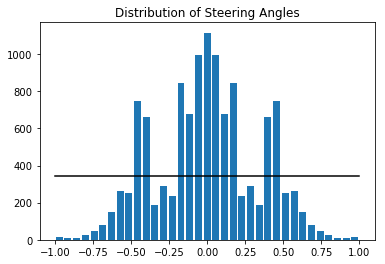

In [39]:
show_dist(y_train_ud)

#### Combine Self-Generated and Udacity Pre-Processed Data

In [40]:
X_train_comb = X_train + X_train_ud
y_train_comb = y_train + y_train_ud

In [41]:
len(X_train_comb)

17270

In [42]:
len(y_train_comb)

17270

In [43]:
## Summary of training, validation, and test sets

# Number of training examples
n_train = len(X_train_comb)

# Number of training examples
n_valid = len(X_valid)

# Number of test examples
n_test = len(X_test)

# Verify that all counts match
print('Number of training samples: ', n_train)
print('Number of validation samples: ', n_valid)
print('Number of test samples: ', n_test)
print('Total: ', n_train + n_valid + n_test)

Number of training samples:  17270
Number of validation samples:  345
Number of test samples:  35
Total:  17650


### 3.7 | Pipeline status check &mdash; Where are we at?
We've done a lot already. Let's take a minute to see where we're at. There are many steps in the pipeline, so it's easy to get lost. 

<br>
**Completed Steps** &mdash; Here's what we've done so far:

**1** - Load and examine the data, plus a little hygiene <br>
**2** - Split the data into training, validation, and test sets <br>
**3** - Pre-process the training data to make it easier for the model to extract the most important features <br>
<br>
<br>
**Next Steps** &mdash; In the subsequent parts of the pipeline, we will:

**4** - Feed the training sets into a generator to undergoe further augmentation (e.g. smoothing, random brightness, affine transformations). This step is only applied to training data, not validation or test data. <br>
**5** - Feed the augmented training data into the model where it is normalized, cropped, and resized <br>
**6** - Train the model on the augmented data set <br>
**7** - Test the model on the validation set

---

## Step 4: Data Generator 

### 4.1 | Overview

### 4.2 | Image Smoothing

After reviewing the various smoothing techniques discussed [here in the OpenCV docs](http://docs.opencv.org/3.1.0/d4/d13/tutorial_py_filtering.html), I decided to use `cv2.bilateralFilter()`. While the operation is slower than the other filters, it has the advantage of removing noise from the image **while preserving the edges**. A more in depth discussion on bilateral filtering can be found [here](http://homepages.inf.ed.ac.uk/rbf/CVonline/LOCAL_COPIES/MANDUCHI1/Bilateral_Filtering.html) (University of Edinburgh). 

In [44]:
def smooth(image_data):
    blur_filter = (5, 80, 80)
    
    if isinstance(image_data, str):
        image = mpimg.imread(get_img_dir(source) + image_data)
    else:
        image = image_data
    
    img_blur = cv2.bilateralFilter(image, blur_filter[0], blur_filter[1], blur_filter[2])
    
    return img_blur

In [ ]:
## Preview smoothed images

index = random.randint(0, len(track1_clean))

# Select a random set of images to crop
center_img_crop = crop(track1_clean[index][0])
left_img_crop = crop(track1_clean[index][1])
right_img_crop = crop(track1_clean[index][2])

# Create smoothed versions
center_img_blur = smooth(center_img_crop)
left_img_blur = smooth(left_img_crop)
right_img_blur = smooth(right_img_crop)
    
# Display visualizations in the notebook
plt.figure(figsize=(20,6))

# Cropped versions
plt.subplot2grid((2, 3), (0, 0));
plt.axis('off')
plt.title('Left Camera')
plt.imshow(left_img_crop, cmap="gray")

plt.subplot2grid((2, 3), (0, 1));
plt.axis('off')
plt.title('Center Camera')
plt.imshow(center_img_crop, cmap="gray")

plt.subplot2grid((2, 3), (0, 2));
plt.axis('off')
plt.title('Right Camera')
plt.imshow(right_img_crop, cmap="gray")

# Flipped version
plt.subplot2grid((2, 3), (1, 0));
plt.axis('off')
plt.title('Left Camera (smoothed)')
plt.imshow(left_img_blur, cmap="gray")

plt.subplot2grid((2, 3), (1, 1));
plt.axis('off')
plt.title('Center Camera (smoothed)')
plt.imshow(center_img_blur, cmap="gray")

plt.subplot2grid((2, 3), (1, 2));
plt.axis('off')
plt.title('Right Camera (smoothed)')
plt.imshow(right_img_blur, cmap="gray")

In [ ]:
# TEMPORARY - FOR TESTING

# Smooth the images using a bilateral filter - this is compute intensive, so we do it after pruning
blur_data = [(smooth(i[0]), i[1]) for i in track1_eq]

In [ ]:
# # Smooth the images using a bilateral filter - this is compute intensive, so we do it after pruning
# blur_data = [(smooth(i[0]), i[1]) for i in eq_data]

#### Apply smoothing to dataset
The above preview looks good. The image has ample noise reduction with very little blurring of the edges. So, we can now apply this effect to our dataset.

In [ ]:
track1_blur = [(smooth(i[0]), i[1]) for i in track1_eq]

In [ ]:
## Verify smoothing effect

index = random.randint(0, len(track1_blur))

plt.figure(figsize=(10,4))
plt.axis('off')
plt.imshow(track1_blur[index][0], cmap="gray")

### 4.3 | Change Brightness

Generates batches of tensor image data that is augmented based on a chosen set of tranformation parameters (e.g. rotation, shift, shear, zoom).

In [45]:
# Randomly shift brightness

def brightness(image):
    # Convert to HSV from RGB 
    hsv = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
    
    # Generate random brightness
    rand = random.uniform(0.6, 1)
    hsv[:,:,2] = rand*hsv[:,:,2]
    
    # Convert back to RGB 
    new_img = cv2.cvtColor(hsv, cv2.COLOR_HSV2RGB)
    
    return new_img 

### 4.4 | Horizon Shift

In [46]:
# Randomly shift horizon

def horizon(image):
    h, w, _ = image.shape
    horizon = 2*h/5
    v_shift = np.random.randint(-h/8,h/8)
    pts1 = np.float32([[0,horizon],[w,horizon],[0,h],[w,h]])
    pts2 = np.float32([[0,horizon+v_shift],[w,horizon+v_shift],[0,h],[w,h]])
    M = cv2.getPerspectiveTransform(pts1,pts2)
    new_img = cv2.warpPerspective(image,M,(w,h), borderMode=cv2.BORDER_REPLICATE)
    
    return new_img

### 4.5 | Affine Transformations (rotation, shift, zoom)

In [47]:
# Combine the brightness and horizon functions so they can be executed within the Keras ImageDataGenerator

def augment(image):
#     blur_img = smooth(image)
    aug_img = brightness(image)
    aug_img = horizon(aug_img)
    
    return aug_img

In [50]:
# Image transformation function

image = np.empty((64, 64, 3), dtype='uint8')

keras_datagen = ImageDataGenerator(
#     zca_whitening=True,
    rotation_range=1,
    width_shift_range=0.04,
    height_shift_range=0.04,
#     shear_range=0.05,
    zoom_range=0.02,
#     channel_shift_range=10.0,
    fill_mode='nearest',
#     preprocessing_function=augment
)


### 4.6 |  Resizing

In [49]:
## Resize function

resized_shape = (64, 64, 3)

def resize(image_array):
    img_resized = cv2.resize(image_array, (resized_shape[0], resized_shape[1]))
    
    return img_resized

In [ ]:
## Preview resized images

index = random.randint(0, len(track1_clean))

# Select a random set of images to crop
center_img_crop = crop(track1_clean[index][0])
left_img_crop = crop(track1_clean[index][1])
right_img_crop = crop(track1_clean[index][2])

# Create resized versions
center_img_resized = resize(center_img_crop)
left_img_resized = resize(left_img_crop)
right_img_resized = resize(right_img_crop)

# Calculate steering angles
center_steer = float(track1_clean[index][3])
left_steer = None
left_steer_resized = None 
right_steer = None
right_steer_resized = None
if center_steer > turn_thresh:
    left_steer = steer_adj(center_steer)
if center_steer < -turn_thresh:
    right_steer = -steer_adj(center_steer)
    
# Display visualizations in the notebook
plt.figure(figsize=(20,7))

# Cropped versions
plt.subplot2grid((2, 3), (0, 0));
plt.axis('off')
plt.title('Left Camera (cropped)')
plt.text(0, left_img_crop.shape[0]+15, ('shape: ' + str(left_img_crop.shape)))
plt.text(0, left_img_crop.shape[0]+30, ('steering angle: ' + str(left_steer)))
plt.imshow(left_img_crop, cmap="gray")

plt.subplot2grid((2, 3), (0, 1));
plt.axis('off')
plt.title('Center Camera (cropped)')
plt.text(0, center_img_crop.shape[0]+15, ('shape: ' + str(center_img_crop.shape)))
plt.text(0, center_img_crop.shape[0]+30, ('steering angle: ' + str(center_steer)))
plt.imshow(center_img_crop, cmap="gray")

plt.subplot2grid((2, 3), (0, 2));
plt.axis('off')
plt.title('Right Camera (cropped)')
plt.text(0, right_img_crop.shape[0]+15, ('shape: ' + str(right_img_crop.shape)))
plt.text(0, right_img_crop.shape[0]+30, ('steering angle: ' + str(right_steer)))
plt.imshow(right_img_crop, cmap="gray")

# Resized version
plt.subplot2grid((2, 3), (1, 0));
plt.axis('off')
plt.title('Left Camera (cropped + resized)')
plt.text(0, left_img_resized.shape[0]+15, ('shape: ' + str(left_img_resized.shape)))
plt.text(0, left_img_resized.shape[0]+30, ('steering angle: ' + str(left_steer)))
plt.imshow(left_img_resized, cmap="gray")

plt.subplot2grid((2, 3), (1, 1));
plt.axis('off')
plt.title('Center Camera (cropped + resized)')
plt.text(0, center_img_resized.shape[0]+15, ('shape: ' + str(center_img_resized.shape)))
plt.text(0, center_img_resized.shape[0]+30, ('steering angle: ' + str(center_steer)))
plt.imshow(center_img_resized, cmap="gray")

plt.subplot2grid((2, 3), (1, 2));
plt.axis('off')
plt.title('Right Camera (cropped + resized)')
plt.text(0, right_img_resized.shape[0]+15, ('shape: ' + str(right_img_resized.shape)))
plt.text(0, right_img_resized.shape[0]+30, ('steering angle: ' + str(right_steer)))
plt.imshow(right_img_resized, cmap="gray")

### 4.7 | Preview sample of fully transformed images

In [ ]:
## Create AUGMENTED training sets **WORKING VERSION**

sample = random.sample(range(1, len(udacity_3cam)), 16)

X_batch = [(udacity_3cam[i][0], udacity_3cam[i][2]) for i in sample]
y_batch = [udacity_3cam[i][1] for i in sample]

X_images = np.empty((0, 160, 320, 3), dtype='uint8')
y_angles = np.empty(0, dtype='float32')

source = default_source

for i in range(len(y_batch)):
    # retrieve the image from local directory
    source = str(X_batch[i][1])
    filename = str(X_batch[i][0])
    img_path = get_img_dir(source) + filename
    img = [mpimg.imread(img_path.strip())]
    angle = [y_batch[i]]
    X_images = np.append(X_images, img, axis=0)
    y_angles = np.append(y_angles, angle, axis=0) 
    
X_aug = np.empty((0, 160, 320, 3))
y_aug = np.empty(0, dtype='float32')

print('Augmenting Image Data...')

# seed = random.randint(1, len(y_batch))
# datagen.fit(X_images)

for X,y in keras_datagen.flow(X_images, y_angles, batch_size=len(y_batch)):       
    X_aug = np.append(X_aug, X, axis=0)
    y_aug = np.append(y_aug, y, axis=0)
    
    if len(y_aug) == len(y_batch):
        break

X_aug = X_aug.astype(np.uint8)

print('Augmentation Complete.')



### 4.8 | Integrate all transformations into single function

In [51]:
## Transformation function ** V 2 **
 
def transform(X_batch, y_batch):
    '''Applies a random set of transformations which are defined by the 
    keras_datagen() function and uses the Keras ImageDataGenerator.
    
    Arguments:
    X_batch: a numpy array of images
    y_batch: a numpy array of steering angles
        
    Returns:
    X_aug: a numpy array of transformed image data
    y_aug: a numpy array of steering angles

    '''
    h, w, c = resized_shape
    X_aug = np.empty((0, h, w, c))
    y_aug = np.empty(0, dtype='float32')
        
    n_aug = (img_ratio-1)     # number of augmented images to create for every input image
    
    for X,y in keras_datagen.flow(X_batch, y_batch, batch_size=len(y_batch)):       
        X_aug = np.append(X_aug, X, axis=0)
        y_aug = np.append(y_aug, y, axis=0)
        
        if X_aug.shape[0] == n_aug*X_batch.shape[0]:
            break
    
    X_aug = X_aug.astype(np.uint8)
    
    return (X_aug, y_aug)

### 4.9 | Batch Generator

In [52]:
def generator(images, angles, val=False):
    '''Generates batches of images to feed into the model. 
    
    For each input image, four different versions are generated:
    img_1 : original version
    img_2 : flipped version of 1
    img_3 : version of 1 with other random transformations (for training only)
    img_4 : version of 2 with other random transformations (for training only)
    
    Arguments:
    images: a list of image filenames
    angles: a list of angles
    source: the original data source, 'udacity' or 'self'
    val: whether the data is being generated for validation (False by default)
    
    Yields: 
    X_batch: a numpy array of image data
    y_batch: a numpy array of steering angles
    
    '''
    images, angles = shuffle(images, angles, random_state=0)
    
    h, w, c = resized_shape
    X_batch = np.empty((0, h, w, c), dtype='uint8')
    y_batch = np.empty(0, dtype='float32')
    
    
    while True:
        for i in range(len(angles)):
#             print('images[{}] = {}'.format(i, images[i]))
#             print('images[{}].shape = {}'.format(i, images[i].shape))
            img = [resize(crop(smooth(images[i])))]
#             print('img.shape = {}'.format(i, img[0].shape))
            ang = [angles[i]]
#             print('X_batch.shape = {}'.format(X_batch.shape))
            X_batch = np.append(X_batch, img, axis=0)
#             print('img appended to X_batch')
            y_batch = np.append(y_batch, ang, axis=0)
#             print('ang appended to y_batch')
            
            # Augmentation process; for training images only
            if not val:
#                 print('augmentation started...')
                # apply other transformations
                img_aug, ang_aug = transform(X_batch[-1:], y_batch[-1:])
#                 print('augmentation complete.')
#                 print('appending to batch...')
                X_batch = np.append(X_batch, img_aug, axis=0)
                y_batch = np.append(y_batch, ang_aug, axis=0)
#                 print('appending complete.')
            
            # Yield batch
            if X_batch.shape[0] >= batch_size:
                X_batch, y_batch = shuffle(X_batch[0:batch_size], y_batch[0:batch_size], random_state=0)
                yield (X_batch, y_batch)
                X_batch = np.empty((0, h, w, c), dtype='uint8')
                y_batch = np.empty(0, dtype='float32')

In [ ]:
## Display sample of the ORIGINAL training images

fig = plt.figure(figsize=(20,16))

orig_images = X_images
sample = random.sample(range(len(X_aug)), 16)

for i in range(16):
    img = orig_images[sample[i]]
    ax = fig.add_subplot(5,4,i+1)
    ax.imshow(img.squeeze(), cmap="gray", interpolation='nearest')
    plt.axis('off')
plt.show()

In [ ]:
## Display sample of training images with POSITIONAL SHIFTS (width, height rotation, horizon)

fig = plt.figure(figsize=(20,16)) 

sample = random.sample(range(len(X_aug)), 16)

for i in range(16):
    img = X_aug[i]
    ax = fig.add_subplot(5,4,i+1)
    ax.imshow(img.squeeze(), cmap="gray", interpolation='nearest')
    plt.axis('off')
plt.show()

In [ ]:
## Display sample of training images with BRIGHTNESS SHIFT 

fig = plt.figure(figsize=(20,16)) 

sample = random.sample(range(len(X_aug)), 16)

for i in range(16):
    img = X_aug[i]
    ax = fig.add_subplot(5,4,i+1)
    ax.imshow(img.squeeze(), cmap="gray", interpolation='nearest')
    plt.axis('off')
plt.show()

---
## Step 3: Model Architecture
---

### Model

In [53]:
## Global variables and parameters

lr = 1e-4        # learning rate
reg = l2(1e-3)   # L2 reg
drop = 0.5       # default dropout rate

d_str = (2, 2)     # default strides
d_act = 'elu'      # default activation function
d_pad = 'same'     # default padding


In [54]:
## Create and reset the model  ** V1 - NVIDIA ** 

model = Sequential()

model.add(Lambda(lambda x: x/255 - 0.5, input_shape=resized_shape))

model.add(Conv2D(24, 5, strides=d_str, padding=d_pad, activation=d_act,  kernel_regularizer=reg))
model.add(Conv2D(36, 5, strides=d_str, padding=d_pad, activation=d_act,  kernel_regularizer=reg))
model.add(Conv2D(48, 5, strides=d_str, padding=d_pad, activation=d_act,  kernel_regularizer=reg))

model.add(Conv2D(64, 3, strides=d_str, padding=d_pad, activation=d_act,  kernel_regularizer=reg))
model.add(Conv2D(64, 3, strides=d_str, padding=d_pad, activation=d_act,  kernel_regularizer=reg))

model.add(Flatten())
model.add(Dense(150, activation=d_act,  kernel_regularizer=reg))
# model.add(Dropout(drop))
model.add(Dense(50, activation=d_act,  kernel_regularizer=reg))
# model.add(Dropout(drop))
model.add(Dense(10, activation=d_act,  kernel_regularizer=reg))
# model.add(Dropout(drop))
model.add(Dense(1))

# Compile and preview the model
model.compile(optimizer=Adam(lr=lr), loss='mean_squared_error', metrics=['accuracy'])

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lambda_1 (Lambda)            (None, 64, 64, 3)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 32, 32, 24)        1824      
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 16, 16, 36)        21636     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 8, 8, 48)          43248     
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 4, 4, 64)          27712     
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 2, 2, 64)          36928     
_________________________________________________________________
flatten_1 (Flatten)          (None, 256)               0         
__________

## Training

In [55]:
# Fetch images for validation and test sets (to match shape of training set)

source = 'track1/more-turns'
X_valid_img = []

for i in range(len(X_valid)):
    img = mpimg.imread(get_img_dir(source) + X_valid[i])
    X_valid_img.append(img)

X_test_img = []

for i in range(len(X_test)):
    img = mpimg.imread(get_img_dir(source) + X_test[i])
    X_test_img.append(img)

    
print('X_valid_img[0].shape =', X_valid_img[0].shape)    
print('X_test_img[0].shape =', X_test_img[0].shape)

X_valid_img[0].shape = (160, 320, 3)
X_test_img[0].shape = (160, 320, 3)


In [56]:
from keras.models import load_model

model = load_model('models/model.h5')

In [57]:
## Train and save the model  **T1 MORE TURNS** (sans brightness and horizon)

epochs = 5
batch_size = 32

img_ratio = 4   # = generator output per input image

train_steps = (img_ratio * len(X_train)) // batch_size
val_steps = len(X_valid_img) // batch_size

train_gen = generator(X_train, y_train, val=False)
val_gen = generator(X_valid_img, y_valid, val=True)

checkpoint = ModelCheckpoint('models/checkpoints/model_{epoch:02d}.h5', monitor='val_loss', save_best_only=True)
    
model.fit_generator(train_gen, steps_per_epoch=train_steps, epochs=epochs, \
                    validation_data=val_gen, validation_steps=val_steps, verbose=1, callbacks=[checkpoint])

print('\nDone Training')

# Save model and weights
model_json = model.to_json()
with open("models/model.json", "w") as json_file:
    json_file.write(model_json)
model.save("models/model.h5")
print("Model saved to disk")

Epoch 1/5
646/646 [==============================] - 39s - loss: 0.0971 - acc: 0.0873 - val_loss: 0.0780 - val_acc: 0.5719
Epoch 2/5
646/646 [==============================] - 37s - loss: 0.0899 - acc: 0.0892 - val_loss: 0.0786 - val_acc: 0.5656
Epoch 3/5
646/646 [==============================] - 37s - loss: 0.0876 - acc: 0.0894 - val_loss: 0.0793 - val_acc: 0.5594
Epoch 4/5
646/646 [==============================] - 37s - loss: 0.0859 - acc: 0.0907 - val_loss: 0.0775 - val_acc: 0.5687
Epoch 5/5
646/646 [==============================] - 37s - loss: 0.0847 - acc: 0.0912 - val_loss: 0.0773 - val_acc: 0.5781

Done Training
Model saved to disk


In [74]:
from keras.models import load_model

model = load_model('models/model.h5')

In [58]:
## Train and save the model

epochs = 5
batch_size = 64

img_ratio = 4   # = generator output per input image

train_steps = (img_ratio * len(X_train_comb)) // batch_size
val_steps = len(X_valid_img) // batch_size

train_gen = generator(X_train_comb, y_train_comb, val=False)
val_gen = generator(X_valid_img, y_valid, val=True)

checkpoint = ModelCheckpoint('models/checkpoints/model_{epoch:02d}.h5', monitor='val_loss', save_best_only=True)
    
model.fit_generator(train_gen, steps_per_epoch=train_steps, epochs=epochs, \
                    validation_data=val_gen, validation_steps=val_steps, verbose=1, callbacks=[checkpoint])

print('\nDone Training')

# Save model and weights
model_json = model.to_json()
with open("models/model.json", "w") as json_file:
    json_file.write(model_json)
model.save("models/model.h5")
print("Model saved to disk")

Epoch 1/5
1079/1079 [==============================] - 123s - loss: 0.0705 - acc: 0.0878 - val_loss: 0.0695 - val_acc: 0.5750
Epoch 2/5
1079/1079 [==============================] - 122s - loss: 0.0649 - acc: 0.0883 - val_loss: 0.0654 - val_acc: 0.5906
Epoch 3/5
1079/1079 [==============================] - 121s - loss: 0.0630 - acc: 0.0887 - val_loss: 0.0633 - val_acc: 0.5750
Epoch 4/5
1079/1079 [==============================] - 121s - loss: 0.0620 - acc: 0.0890 - val_loss: 0.0601 - val_acc: 0.5844
Epoch 5/5
1079/1079 [==============================] - 122s - loss: 0.0614 - acc: 0.0890 - val_loss: 0.0594 - val_acc: 0.5813

Done Training
Model saved to disk


In [ ]:
## Train and save the model  **BOTH TRACKS** round 2

epochs = 5
batch_size = 64

img_ratio = 2   # = generator output per input image

train_steps = (img_ratio * len(X_train)) // batch_size
val_steps = len(X_valid_img) // batch_size

train_gen = generator(X_train, y_train, val=False)
val_gen = generator(X_valid_img, y_valid, val=True)

checkpoint = ModelCheckpoint('models/checkpoints/model_{epoch:02d}.h5', monitor='val_loss', save_best_only=True)
    
model.fit_generator(train_gen, steps_per_epoch=train_steps, epochs=epochs, \
                    validation_data=val_gen, validation_steps=val_steps, verbose=1, callbacks=[checkpoint])

print('\nDone Training')

# Save model and weights
model_json = model.to_json()
with open("models/model.json", "w") as json_file:
    json_file.write(model_json)
model.save("models/model.h5")
print("Model saved to disk")

In [ ]:
from keras.models import load_model

model = load_model('model.h5')